In [1]:
path = "G:\\acra\\NLMCXR_reports"

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as et
import re
import seaborn as sns
from matplotlib import pyplot

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
start = "\033[1m"; end = "\033[0;0m"

In [4]:
def extract_word(word,regex):
    result = []
    for i in range(0,len(word)):
        string = str(word[i])
        result.append(re.search(regex, string).group(1))
    return result

def add_elements(word):
    temp_list = []
    length = len(word) - 1
    for i in range(0,5):
        if i <= length:
            temp_list.append(word[i])
        else:
            temp_list.append("")
    return temp_list

def remove_html(string,tag,punct):
    mesh_list = []
    clean = re.compile(tag)
    for i in range(0,len(string)):
        temp = re.sub(clean,punct,str(string[i]))
        mesh_list.append(temp.replace("\n",''))
    return mesh_list

In [5]:
cols = ["Comparison","Indication","Findings","Impression","Mesh","Image1","Image2","Image3","Image4","Image5"]

labels = pd.DataFrame(columns=cols)

for file in os.listdir(path):
    filepath = os.path.join(path, file)
    with open(filepath) as fp:
        contents = fp.read()
        soup = BeautifulSoup(contents, 'html.parser')
        
        abstract  = soup.find_all("abstracttext")
        abs_temp  = extract_word(abstract,'">(.*?)</abstracttext>')
       
        imageid = soup.find_all("url")
        img_temp  = extract_word(imageid,'act/(.*?)</url>')
        img_temp = add_elements(img_temp)
        
        mesh = soup.find_all("mesh")
        
        concat = pd.Series(dict(zip(labels.columns,abs_temp+mesh+img_temp)))
        labels = labels.append(concat,ignore_index=True)

In [6]:
labels.shape

(3956, 10)

In [7]:
labels.head(1)

,Comparison,Indication,Findings,Impression,Mesh,Image1,Image2,Image3,Image4,Image5
0,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,"[\n, [normal], \n]",CXR1_1_IM-0001-3001.jpg,CXR1_1_IM-0001-4001.jpg,,,


In [8]:
sep = "_"
idx=0
img_name = labels.Image1.str.split(sep,1)
img_title = [x[0] for x in img_name]
labels.insert(loc=idx, column='ID', value=img_title)

In [9]:
labels.head(2)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image1,Image2,Image3,Image4,Image5
0,CXR1,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,"[\n, [normal], \n]",CXR1_1_IM-0001-3001.jpg,CXR1_1_IM-0001-4001.jpg,,,
1,CXR10,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,"[\n, [Calcified Granuloma/lung/upper lobe/righ...",CXR10_IM-0002-1001.jpg,CXR10_IM-0002-2001.jpg,,,


In [10]:
##Converting all jpg extension in report png as our source images are all png
labels.Image1 = labels.apply(lambda x:x.Image1.replace('jpg','png'),axis=1)
labels.Image2 = labels.apply(lambda x:x.Image2.replace('jpg','png'),axis=1)
labels.Image3 = labels.apply(lambda x:x.Image3.replace('jpg','png'),axis=1)
labels.Image4 = labels.apply(lambda x:x.Image4.replace('jpg','png'),axis=1)
labels.Image5 = labels.apply(lambda x:x.Image5.replace('jpg','png'),axis=1)

In [11]:
labels.head(3)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image1,Image2,Image3,Image4,Image5
0,CXR1,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,"[\n, [normal], \n]",CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,,,
1,CXR10,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,"[\n, [Calcified Granuloma/lung/upper lobe/righ...",CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png,,,
2,CXR100,None.,,Both lungs are clear and expanded. Heart and m...,No active disease.,"[\n, [normal], \n]",CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,,,


In [12]:
## As Beautifulsoap did not work when more than 1 tag is extracted (major/automatic tags are dynamic -  
## - mesh was extracted in full)
## Value populated as such to df and manipulated as below to get the content


tag_list = "<mesh>|<major>|<automatic>|</mesh>"
html = "<.*?>"
mesh_list = remove_html(labels["Mesh"],tag_list,'')
mesh_list = remove_html(mesh_list,html,',')

labels["Mesh"] = mesh_list

## Replacing the special characters in between to underscore - better for analysis
labels["Mesh"] = labels["Mesh"].str.replace('/','_').replace(', ','_').replace(' ','_')

In [13]:
labels.head(2)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image1,Image2,Image3,Image4,Image5
0,CXR1,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,"normal,",CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,,,
1,CXR10,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,"Calcified Granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png,,,


In [14]:
labels.to_csv('Raw_report.csv',index=None)

In [15]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3956 entries, 0 to 3955
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          3956 non-null   object
 1   Comparison  3956 non-null   object
 2   Indication  3956 non-null   object
 3   Findings    3956 non-null   object
 4   Impression  3956 non-null   object
 5   Mesh        3956 non-null   object
 6   Image1      3956 non-null   object
 7   Image2      3956 non-null   object
 8   Image3      3956 non-null   object
 9   Image4      3956 non-null   object
 10  Image5      3956 non-null   object
dtypes: object(11)
memory usage: 340.1+ KB


In [16]:
## Replacing blanks/spaces to "Nan"
labels.replace(r'^\s*$', np.nan, regex=True,inplace=True)

In [17]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3956 entries, 0 to 3955
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          3852 non-null   object
 1   Comparison  3334 non-null   object
 2   Indication  3866 non-null   object
 3   Findings    3426 non-null   object
 4   Impression  3922 non-null   object
 5   Mesh        3956 non-null   object
 6   Image1      3852 non-null   object
 7   Image2      3406 non-null   object
 8   Image3      198 non-null    object
 9   Image4      17 non-null     object
 10  Image5      1 non-null      object
dtypes: object(11)
memory usage: 340.1+ KB


In [18]:
print(labels.isnull().sum())

ID             104
Comparison     622
Indication      90
Findings       530
Impression      34
Mesh             0
Image1         104
Image2         550
Image3        3758
Image4        3939
Image5        3955
dtype: int64


In [19]:
## Dropping the 104 entries without image info in the reports
labels.dropna(axis=0, subset=['ID'], inplace=True)
labels = labels.reset_index(drop=True)

In [20]:
## Dropping rows which do not have both Findings and Impression
diag_cols = ["Findings","Impression"]
#labels[labels[diag_cols].isnull().all(axis=1)].count()
labels = labels[~labels[diag_cols].isnull().all(axis=1)]
labels = labels.reset_index(drop=True)

In [21]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3827 entries, 0 to 3826
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          3827 non-null   object
 1   Comparison  3253 non-null   object
 2   Indication  3766 non-null   object
 3   Findings    3338 non-null   object
 4   Impression  3821 non-null   object
 5   Mesh        3827 non-null   object
 6   Image1      3827 non-null   object
 7   Image2      3392 non-null   object
 8   Image3      197 non-null    object
 9   Image4      17 non-null     object
 10  Image5      1 non-null      object
dtypes: object(11)
memory usage: 329.0+ KB


In [22]:
print(labels.isnull().sum())

ID               0
Comparison     574
Indication      61
Findings       489
Impression       6
Mesh             0
Image1           0
Image2         435
Image3        3630
Image4        3810
Image5        3826
dtype: int64


In [23]:
## CXR3368 - row#2504 has the impression misproduced in Findings.  Corrected
idx = 2504
labels["Impression"].loc[idx] = "Low lung volumes without acute cardiopulmonary findings"
labels["Findings"].loc[idx] = "The trachea is midline. The cardiomediastinal silhouette is normal. Low lung volumes causing mild bronchovascular crowding. No focal airspace consolidation is seen. There is no pleural effusion. There is no large pneumothorax. Visualized bony structures reveal no acute abnormalities"

In [24]:
labels.iloc[idx]

ID                                                      CXR3368
Comparison      Chest x-XXXX, 2 views PA and lateral from XXXX.
Indication    The patient is a XXXX-year-old XXXX with a his...
Findings      The trachea is midline. The cardiomediastinal ...
Impression    Low lung volumes without acute cardiopulmonary...
Mesh          Lung_hypoinflation,Markings_bronchovascular_mild,
Image1                            CXR3368_IM-1620-0001-0001.png
Image2                            CXR3368_IM-1620-0001-0002.png
Image3                                                      NaN
Image4                                                      NaN
Image5                                                      NaN
Name: 2504, dtype: object

In [25]:
labels[(labels["Findings"].str.contains("Degenerative changes thoracic spine")==True) &
       (labels["Indication"].str.contains("female")==True)]

,ID,Comparison,Indication,Findings,Impression,Mesh,Image1,Image2,Image3,Image4,Image5
671,CXR1634,PA lateral views of the chest dated XXXX.,"XXXX-year-old female, chronic airway obstructi...",Calcified granulomas. Calcified hilar XXXX. No...,Hyperexpanded lung XXXX compatible with COPD. ...,"Calcified Granuloma_multiple,Calcinosis_lung_h...",CXR1634_IM-0414-2002.png,CXR1634_IM-0414-3003.png,NaN,NaN,NaN
1331,CXR2257,None,"XXXX year old female, hypertension, preop thyr...",No focal areas of consolidation. Heart size no...,No acute cardiopulmonary abnormality. .,"Thoracic Vertebrae_degenerative,degenerative c...",CXR2257_IM-0849-1001.png,CXR2257_IM-0849-2001.png,NaN,NaN,NaN
2117,CXR3009,Portable chest dated XXXX.,"XXXX-year-old female, parotid gland disease, r...",No focal areas of consolidation. No pleural ef...,No acute cardiopulmonary abnormality. .,"Thoracic Vertebrae_degenerative,degenerative c...",CXR3009_IM-1389-1001.png,NaN,NaN,NaN,NaN
2748,CXR3597,Portable chest dated XXXX.,"XXXX-year-old female, bone marrow transplant w...",Left XXXX XXXX noted with tip approximating th...,No acute cardiopulmonary abnormality. .,"Catheters, Indwelling_left,Thoracic Vertebrae_...",CXR3597_IM-1775-1001.png,CXR3597_IM-1775-2001.png,NaN,NaN,NaN
3640,CXR824,None,"XXXX-year-old female, tobacco use, preop.",There are no focal areas of consolidation. No ...,NaN,"Calcified Granuloma,Thoracic Vertebrae_degener...",CXR824_IM-2354-1001.png,CXR824_IM-2354-2001.png,NaN,NaN,NaN
3823,CXR997,Chest x-XXXX dated XXXX at XXXX hours.,"XXXX-year-old female, transplant workup.",Calcified mediastinal XXXX. No focal areas of ...,No acute cardiopulmonary abnormality. .,"Calcinosis_mediastinum,Thoracic Vertebrae_dege...",CXR997_IM-2479-1001.png,CXR997_IM-2479-2001.png,NaN,NaN,NaN


In [26]:
idx = 3640
## Using the above matching rows and updating the "Impression"
labels["Impression"].loc[idx] = labels["Impression"].loc[2748]

In [27]:
## CXR1084 - row 93 similar to CXR3597 (above) except that lung volume is good
idx=93
labels["Impression"].loc[idx] = labels["Impression"].loc[2748]

In [28]:
idx = 2390
labels[(labels["Findings"].str.contains("osseous")==True) & 
       (labels["Findings"].str.contains("mediastinal contours are normal")==True) &
       (labels["Indication"].str.contains("female")==True)]

,ID,Comparison,Indication,Findings,Impression,Mesh,Image1,Image2,Image3,Image4,Image5
232,CXR1219,None available,XXXX-year-old female with syncope,Heart size and mediastinal contours are normal...,No acute cardiopulmonary abnormality.,"normal,",CXR1219_IM-0146-1001.png,CXR1219_IM-0146-2001.png,NaN,NaN,NaN
2390,CXR326,"XXXX, XXXX",XXXX-year-old female with XXXX for one XXXX,The lungs are clear. Heart size and mediastina...,NaN,"normal,",CXR326_IM-1546-12012.png,CXR326_IM-1546-2002.png,NaN,NaN,NaN


In [29]:
## Updaing per above evidence
labels["Impression"].loc[idx] = labels["Impression"].loc[232]

In [30]:
idx=2768
labels[#(labels["Findings"].str.contains("Cardiomegaly")==True) & 
       (labels["Findings"].str.contains("atelectasis")==True) &
       (labels["Indication"].str.contains("Dyspnea")==True)]

,ID,Comparison,Indication,Findings,Impression,Mesh,Image1,Image2,Image3,Image4,Image5
445,CXR1419,None available,Dyspnea and congestion,Cardiac silhouette and pulmonary vascularity a...,Minimal bibasilar focal atelectasis.,Pulmonary Atelectasis_base_bilateral_focal_mil...,CXR1419_IM-0267-1001.png,CXR1419_IM-0267-2001.png,NaN,NaN,NaN
576,CXR1542,XXXX,Dyspnea,The heart is top normal in size. The mediastin...,Chronic changes without acute disease.,"Atherosclerosis_aorta,Opacity_lung_base_bilate...",CXR1542_IM-0352-1001.png,CXR1542_IM-0352-2001.png,NaN,NaN,NaN
1508,CXR2421,NaN,Dyspnea,The heart is enlarged. The left subclavian ICD...,Stable moderate to marked cardiomegaly.,"Cardiomegaly_severe,Implanted Medical Device_l...",CXR2421_IM-0965-2001.png,NaN,NaN,NaN,NaN
2274,CXR3154,"XXXX, XXXX.","Dyspnea. Midsternal chest pressure, tightness....",There is severe dextroscoliosis of the thoraci...,Low lung volumes with probable mild bibasilar ...,"Scoliosis_thoracic vertebrae_right_severe,Defo...",CXR3154_IM-1486-2001.png,CXR3154_IM-1486-4004.png,NaN,NaN,NaN
2768,CXR3614,XXXX,Dyspnea seen impression,AP and lateral views were obtained. Bibasilar ...,NaN,"Pulmonary Atelectasis_base_bilateral,Pleural E...",CXR3614_IM-1787-2001.png,CXR3614_IM-1787-4001.png,NaN,NaN,NaN
2810,CXR3653,XXXX.,"Dyspnea, XXXX and chills.",The XXXX examination consists of frontal and l...,Low lung volumes with minimal bibasilar atelec...,"Lung_hypoinflation,Pulmonary Atelectasis_base_...",CXR3653_IM-1815-1001.png,CXR3653_IM-1815-3001.png,NaN,NaN,NaN
3372,CXR573,"XXXX XXXX, chest x-XXXX XXXX",Dyspnea.,The XXXX examination consists of frontal and l...,No evidence of acute cardiopulmonary disease o...,"Surgical Instruments,Pulmonary Emphysema_sever...",CXR573_IM-2171-12012.png,CXR573_IM-2171-3001.png,CXR573_IM-2171-4004.png,NaN,NaN


In [31]:
## Based on the Mesh values between CXR3614 & CXR1419
labels["Impression"].loc[idx] = labels["Impression"].loc[445]

In [32]:
## After cleaning only 1 row remaining - No exact match from DB
labels[labels["Impression"].isnull()]

,ID,Comparison,Indication,Findings,Impression,Mesh,Image1,Image2,Image3,Image4,Image5
2391,CXR3260,None,Hypoxia.,1. Cardiomegaly and/or pericardial effusion. 2...,NaN,"Cardiomegaly,Pericardial Effusion,Opacity_lung...",CXR3260_IM-1547-1001.png,CXR3260_IM-1547-2001.png,NaN,NaN,NaN


In [33]:
## Concatenating Images & Captions into single column

img_cols = ["Image1","Image2","Image3","Image4","Image5"]

labels["Image"]   = labels[img_cols].apply(lambda x: ','.join(x.dropna()), axis=1)

labels.drop(img_cols,axis=1,inplace=True)
labels.head()

,ID,Comparison,Indication,Findings,Impression,Mesh,Image
0,CXR1,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,"normal,","CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png"
1,CXR10,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,"Calcified Granuloma_lung_upper lobe_right,calc...","CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png"
2,CXR100,None.,NaN,Both lungs are clear and expanded. Heart and m...,No active disease.,"normal,","CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png"
3,CXR1000,XXXX PA and lateral chest radiographs,"XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...,"Opacity_lung_upper lobe_right,Pulmonary Atelec...","CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001...."
4,CXR1001,None,"dyspnea, subjective fevers, arthritis, immigra...",Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.,Markings_lung_bilateral_interstitial_diffuse_p...,"CXR1001_IM-0004-1001.png,CXR1001_IM-0004-1002.png"


In [34]:
## Splitting images & Captions into multiple rows
df = labels.copy()

s1 = df.Image.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
df1 = pd.concat([s1], axis=1, keys=['Image'])
df2 = (df.drop(['Image'], axis=1).join(df1).reset_index(drop=True))

labels = df2.copy()

In [35]:
## Reading the Lung type dataset to insert the x-ray view (Front/Back - PA; Side - Lateral)
lungLA = pd.read_csv("ImagesLA.csv")
lungPA = pd.read_csv("ImagesPA.csv")
lung = pd.concat([lungPA,lungLA])

In [36]:
lung.columns

Index(['Filename', 'Class'], dtype='object')

In [37]:
lung.head(2)

,Filename,Class
0,CXR1000_IM-0003-1001.png,0
1,CXR1000_IM-0003-3001.png,0


In [38]:
df1 = labels.copy()
df2 = lung.copy()
df1["View"] = df1['Image'].map(df2.set_index('Filename')['Class'])

labels = df1.copy()

In [39]:
labels.head(10)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image,View
0,CXR1,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,"normal,",CXR1_1_IM-0001-3001.png,1.0
1,CXR1,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,"normal,",CXR1_1_IM-0001-4001.png,0.0
2,CXR10,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,"Calcified Granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-1001.png,0.0
3,CXR10,Chest radiographs XXXX.,"XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,"Calcified Granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-2001.png,0.0
4,CXR100,None.,NaN,Both lungs are clear and expanded. Heart and m...,No active disease.,"normal,",CXR100_IM-0002-1001.png,0.0
5,CXR100,None.,NaN,Both lungs are clear and expanded. Heart and m...,No active disease.,"normal,",CXR100_IM-0002-2001.png,1.0
6,CXR1000,XXXX PA and lateral chest radiographs,"XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...,"Opacity_lung_upper lobe_right,Pulmonary Atelec...",CXR1000_IM-0003-1001.png,0.0
7,CXR1000,XXXX PA and lateral chest radiographs,"XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...,"Opacity_lung_upper lobe_right,Pulmonary Atelec...",CXR1000_IM-0003-2001.png,1.0
8,CXR1000,XXXX PA and lateral chest radiographs,"XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...,"Opacity_lung_upper lobe_right,Pulmonary Atelec...",CXR1000_IM-0003-3001.png,0.0
9,CXR1001,None,"dyspnea, subjective fevers, arthritis, immigra...",Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.,Markings_lung_bilateral_interstitial_diffuse_p...,CXR1001_IM-0004-1001.png,0.0


In [40]:
labels.replace(to_replace=[" XXXX","XXXX ","-XXXX","XXXX-",".XXXX","XXXX.","XXXX","year-old "," year-old","year-old","year-old.",
                           "year-old,","year-old,,","year old","year old,","year old."],value="",inplace=True,regex=True)

In [41]:
labels.head(10)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image,View
0,CXR1,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x.,"normal,",CXR1_1_IM-0001-3001.png,1.0
1,CXR1,None.,Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x.,"normal,",CXR1_1_IM-0001-4001.png,0.0
2,CXR10,Chest radiographs.,"male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,"Calcified Granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-1001.png,0.0
3,CXR10,Chest radiographs.,"male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.,"Calcified Granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-2001.png,0.0
4,CXR100,None.,NaN,Both lungs are clear and expanded. Heart and m...,No active disease.,"normal,",CXR100_IM-0002-1001.png,0.0
5,CXR100,None.,NaN,Both lungs are clear and expanded. Heart and m...,No active disease.,"normal,",CXR100_IM-0002-2001.png,1.0
6,CXR1000,PA and lateral chest radiographs,"male,.",There is increased opacity within the right up...,1. Increased opacity in the right upper lobe w...,"Opacity_lung_upper lobe_right,Pulmonary Atelec...",CXR1000_IM-0003-1001.png,0.0
7,CXR1000,PA and lateral chest radiographs,"male,.",There is increased opacity within the right up...,1. Increased opacity in the right upper lobe w...,"Opacity_lung_upper lobe_right,Pulmonary Atelec...",CXR1000_IM-0003-2001.png,1.0
8,CXR1000,PA and lateral chest radiographs,"male,.",There is increased opacity within the right up...,1. Increased opacity in the right upper lobe w...,"Opacity_lung_upper lobe_right,Pulmonary Atelec...",CXR1000_IM-0003-3001.png,0.0
9,CXR1001,None,"dyspnea, subjective fevers, arthritis, immigra...",Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.,Markings_lung_bilateral_interstitial_diffuse_p...,CXR1001_IM-0004-1001.png,0.0


In [42]:
labels.columns

Index(['ID', 'Comparison', 'Indication', 'Findings', 'Impression', 'Mesh',
       'Image', 'View'],
      dtype='object')

In [43]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7437 entries, 0 to 7436
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          7437 non-null   object 
 1   Comparison  6320 non-null   object 
 2   Indication  7318 non-null   object 
 3   Findings    6480 non-null   object 
 4   Impression  7435 non-null   object 
 5   Mesh        7437 non-null   object 
 6   Image       7437 non-null   object 
 7   View        7430 non-null   float64
dtypes: float64(1), object(7)
memory usage: 464.9+ KB


In [44]:
labels.Comparison = labels.apply(lambda x: str(x.Comparison).lower(),axis=1)
labels.Indication = labels.apply(lambda x: str(x.Indication).lower(),axis=1)
labels.Findings = labels.apply(lambda x: str(x.Findings).lower(),axis=1)
labels.Impression = labels.apply(lambda x: str(x.Impression).lower(),axis=1)
labels.Mesh = labels.apply(lambda x: str(x.Mesh).lower(),axis=1)

In [46]:
labels.Comparison = labels.apply(lambda x:str(x.Comparison).rstrip("."),axis=1)
labels.Comparison = labels.apply(lambda x:str(x.Comparison).rstrip(","),axis=1)
labels.Comparison = labels.apply(lambda x:str(x.Comparison).lstrip("."),axis=1)
labels.Comparison = labels.apply(lambda x:str(x.Comparison).lstrip(","),axis=1)

In [48]:
labels.head(5)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image,View
0,CXR1,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x.,"normal,",CXR1_1_IM-0001-3001.png,1.0
1,CXR1,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x.,"normal,",CXR1_1_IM-0001-4001.png,0.0
2,CXR10,chest radiographs,"male, chest pain.",the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process.,"calcified granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-1001.png,0.0
3,CXR10,chest radiographs,"male, chest pain.",the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process.,"calcified granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-2001.png,0.0
4,CXR100,none,nan,both lungs are clear and expanded. heart and m...,no active disease.,"normal,",CXR100_IM-0002-1001.png,0.0


In [49]:
labels.Indication = labels.apply(lambda x:str(x.Indication).rstrip("."),axis=1)
labels.Indication = labels.apply(lambda x:str(x.Indication).rstrip(","),axis=1)
labels.Indication = labels.apply(lambda x:str(x.Indication).lstrip("."),axis=1)
labels.Indication = labels.apply(lambda x:str(x.Indication).lstrip(","),axis=1)

labels.Findings = labels.apply(lambda x:str(x.Findings).rstrip("."),axis=1)
labels.Findings = labels.apply(lambda x:str(x.Findings).rstrip(","),axis=1)
labels.Findings = labels.apply(lambda x:str(x.Findings).lstrip("."),axis=1)
labels.Findings = labels.apply(lambda x:str(x.Findings).lstrip(","),axis=1)

labels.Impression = labels.apply(lambda x:str(x.Impression).rstrip("."),axis=1)
labels.Impression = labels.apply(lambda x:str(x.Impression).rstrip(","),axis=1)
labels.Impression = labels.apply(lambda x:str(x.Impression).lstrip("."),axis=1)
labels.Impression = labels.apply(lambda x:str(x.Impression).lstrip(","),axis=1)

labels.Mesh = labels.apply(lambda x:str(x.Mesh).rstrip("."),axis=1)
labels.Mesh = labels.apply(lambda x:str(x.Mesh).rstrip(","),axis=1)
labels.Mesh = labels.apply(lambda x:str(x.Mesh).lstrip("."),axis=1)
labels.Mesh = labels.apply(lambda x:str(x.Mesh).lstrip(","),axis=1)

In [50]:
labels.head(5)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image,View
0,CXR1,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x,normal,CXR1_1_IM-0001-3001.png,1.0
1,CXR1,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x,normal,CXR1_1_IM-0001-4001.png,0.0
2,CXR10,chest radiographs,"male, chest pain",the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process,"calcified granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-1001.png,0.0
3,CXR10,chest radiographs,"male, chest pain",the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process,"calcified granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-2001.png,0.0
4,CXR100,none,nan,both lungs are clear and expanded. heart and m...,no active disease,normal,CXR100_IM-0002-1001.png,0.0


### Indication Column

In [51]:
## Indication chart
labels_ind = pd.DataFrame(labels.groupby("Indication").size(),columns=["Size"])
labels_ind_top30 = labels_ind.sort_values("Size",ascending=False)[:30]
labels_ind_top30.reset_index(level=0, inplace=True)
labels_ind_top30

,Indication,Size
0,chest pain,577
1,,398
2,dyspnea,180
3,nan,119
4,female with chest pain,115
5,male with chest pain,100
6,shortness of breath,99
7,with chest pain,78
8,with,60
9,female with,60


[Text(0, 0, 'chest pain'),
 Text(1, 0, ''),
 Text(2, 0, 'dyspnea'),
 Text(3, 0, 'nan'),
 Text(4, 0, 'female with chest pain'),
 Text(5, 0, 'male with chest pain'),
 Text(6, 0, 'shortness of breath'),
 Text(7, 0, 'with chest pain'),
 Text(8, 0, 'with'),
 Text(9, 0, 'female with'),
 Text(10, 0, 'male'),
 Text(11, 0, 'woman with chest pain'),
 Text(12, 0, 'male with'),
 Text(13, 0, 'female with dyspnea'),
 Text(14, 0, 'male, chest pain'),
 Text(15, 0, 'female, chest pain'),
 Text(16, 0, 'pain'),
 Text(17, 0, 'female'),
 Text(18, 0, 'male with dyspnea'),
 Text(19, 0, 'syncope'),
 Text(20, 0, 'male, pain'),
 Text(21, 0, 'with shortness of breath'),
 Text(22, 0, 'with dyspnea'),
 Text(23, 0, 'sob'),
 Text(24, 0, 'positive ppd'),
 Text(25, 0, 'cp'),
 Text(26, 0, 'male with shortness of breath'),
 Text(27, 0, 'preop bariatric surgery'),
 Text(28, 0, 'productive'),
 Text(29, 0, 'chronic')]

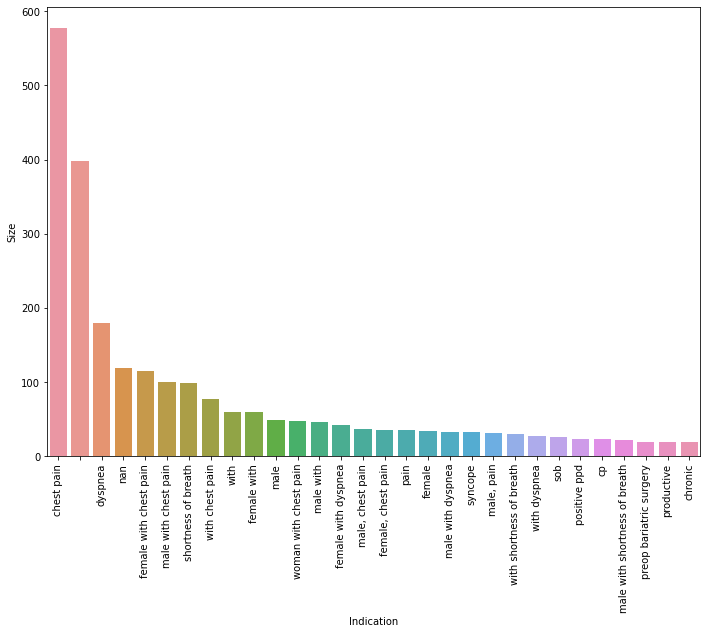

In [52]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

chart = sns.barplot(data=labels_ind_top30,y="Size",x="Indication",ax=ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [53]:
## Counts of sex indication
labels_temp = labels.copy()
labels_temp = labels["Indication"].dropna()
print (start+"Total valid Indications : "+end+str(len(labels_temp)))
print (start+"Total 'Female'          : "+end+str(len(labels_temp[labels_temp.str.contains("female")])))
print (start+"Total 'Male'            : "+end+str(len(labels_temp[labels_temp.str.contains("male")]) - len(labels_temp[labels_temp.str.contains("female")])))
print (start+"Total 'Woman'           : "+end+str(len(labels_temp[labels_temp.str.contains("woman")])))
print (start+"Total 'Man'             : "+end+str(len(labels_temp[labels_temp.str.contains("man")]) - len(labels_temp[labels_temp.str.contains("woman")])))

Total valid Indications : 7437
Total 'Female'          : 1068
Total 'Male'            : 957
Total 'Woman'           : 208
Total 'Man'             : 1


In [54]:
## Create a new Sex column with value updated from Indication
labels['Sex'] = np.where(labels['Indication'].str.contains("male","man"), "male", "")
labels['Sex1'] = np.where((labels['Indication'].str.contains("female","woman")), "female", "")
labels.loc[labels.Sex1=="female","Sex"]="female"
labels.drop("Sex1",axis=1,inplace=True)

In [55]:
labels.sample(10)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image,View,Sex
4991,CXR3435,"ct thoracic spine,; films of spine,","female preoperative for spinal surgery 14,. no...",nan,1. there is cardiomegaly. no pulmonary edema. ...,"cardiomegaly,scoliosis_thoracic vertebrae,calc...",CXR3435_IM-1662-2001.png,1.0,female
7085,CXR833,none,"etoh, assess for malignancy",heart size and pulmonary vascularity appear wi...,1. no evidence of active disease,normal,CXR833_IM-2359-2001.png,1.0,
5808,CXR3821,,with chest pain,"the lungs are clear, and without focal air spa...",no acute cardiopulmonary abnormality,no indexing,CXR3821_IM-1929-1001.png,0.0,
345,CXR1168,none,,both lungs are clear and expanded. heart and m...,no active disease,normal,CXR1168_IM-0112-1002.png,1.0,
4066,CXR2992,none,"786.2,v70.0",the lungs are clear. heart size is normal. no ...,clear lungs. no acute cardiopulmonary abnormal...,"calcified granuloma_lung_base_right,calcified ...",CXR2992_IM-1379-2002.png,0.0,
4546,CXR3225,nan,chest pain,nan,no active disease,normal,CXR3225_IM-1525-1001.png,0.0,
5626,CXR3731,,and,lungs are clear. heart and mediastinum appear ...,negative chest,normal,CXR3731_IM-1865-2001.png,1.0,
1925,CXR1939,none,female with chest pain,lungs are clear. heart size normal. no pneumot...,clear lungs. no acute cardiopulmonary abnormality,"opacity_costophrenic angle_left,opacity,adipos...",CXR1939_IM-0609-1001.png,0.0,female
2223,CXR2087,none,"male, syncope",nan,heart size within normal limits for technique....,normal,CXR2087_IM-0718-1001.png,1.0,male
551,CXR1269,none,female,normal heart size. hyperexpanded lungs without...,"hyperexpanded lungs, otherwise clear","lung_hyperdistention,foreign bodies_breast_left",CXR1269_IM-0181-1001.png,0.0,female


In [56]:
labels["Indication"].replace(to_replace=["woman","woman "," woman","woman,","woman.",
                                         "female","female "," female","female,","female.",
                                         "man","man "," man","man,","man.",
                                         "male","male "," male","male,","male."],
                             value="",inplace=True,regex=True)

In [58]:
labels.Indication = labels.apply(lambda x:str(x.Indication).rstrip("."),axis=1)
labels.Indication = labels.apply(lambda x:str(x.Indication).rstrip(","),axis=1)
labels.Indication = labels.apply(lambda x:str(x.Indication).lstrip("."),axis=1)
labels.Indication = labels.apply(lambda x:str(x.Indication).lstrip(","),axis=1)

In [59]:
labels.head(10)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image,View,Sex
0,CXR1,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x,normal,CXR1_1_IM-0001-3001.png,1.0,
1,CXR1,none,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x,normal,CXR1_1_IM-0001-4001.png,0.0,
2,CXR10,chest radiographs,chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process,"calcified granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-1001.png,0.0,male
3,CXR10,chest radiographs,chest pain,the cardiomediastinal silhouette is within nor...,no acute cardiopulmonary process,"calcified granuloma_lung_upper lobe_right,calc...",CXR10_IM-0002-2001.png,0.0,male
4,CXR100,none,nan,both lungs are clear and expanded. heart and m...,no active disease,normal,CXR100_IM-0002-1001.png,0.0,
5,CXR100,none,nan,both lungs are clear and expanded. heart and m...,no active disease,normal,CXR100_IM-0002-2001.png,1.0,
6,CXR1000,pa and lateral chest radiographs,,there is increased opacity within the right up...,1. increased opacity in the right upper lobe w...,"opacity_lung_upper lobe_right,pulmonary atelec...",CXR1000_IM-0003-1001.png,0.0,male
7,CXR1000,pa and lateral chest radiographs,,there is increased opacity within the right up...,1. increased opacity in the right upper lobe w...,"opacity_lung_upper lobe_right,pulmonary atelec...",CXR1000_IM-0003-2001.png,1.0,male
8,CXR1000,pa and lateral chest radiographs,,there is increased opacity within the right up...,1. increased opacity in the right upper lobe w...,"opacity_lung_upper lobe_right,pulmonary atelec...",CXR1000_IM-0003-3001.png,0.0,male
9,CXR1001,none,"dyspnea, subjective fevers, arthritis, immigra...",interstitial markings are diffusely prominent ...,diffuse fibrosis. no visible focal acute disease,markings_lung_bilateral_interstitial_diffuse_p...,CXR1001_IM-0004-1001.png,0.0,


In [60]:
labels.iloc[1025:1027]

,ID,Comparison,Indication,Findings,Impression,Mesh,Image,View,Sex
1025,CXR150,none,without chest complaints. allergic to tb test...,"heart size, mediastinal contour, and pulmonary...",1. no acute cardiopulmonary abnormality. 2. no...,no indexing,CXR150_IM-0325-0001-0001.png,0.0,female
1026,CXR150,none,without chest complaints. allergic to tb test...,"heart size, mediastinal contour, and pulmonary...",1. no acute cardiopulmonary abnormality. 2. no...,no indexing,CXR150_IM-0325-0001-0002.png,1.0,female


In [61]:
## Remove "with" (1 row has without, this is not replaced)
labels["Indication"].replace(to_replace=["with"," with","with "],value="",inplace=True,regex=True)
labels["Indication"][1025:][:2].replace(to_replace=["out"],value=["without"],inplace=True,regex=True)

In [62]:
## Remove leading/trailing spaces
labels["Indication"] = labels["Indication"].str.lstrip(" ")
labels["Indication"] = labels["Indication"].str.lstrip(",")
labels["Indication"] = labels["Indication"].str.lstrip(".")
labels["Indication"] = labels["Indication"].str.lstrip(";")

labels["Indication"] = labels["Indication"].str.rstrip(" ")
labels["Indication"] = labels["Indication"].str.rstrip(",")
labels["Indication"] = labels["Indication"].str.rstrip(".")
labels["Indication"] = labels["Indication"].str.rstrip(";")
labels["Indication"] = labels["Indication"].str.rstrip(",,-")


In [63]:
## Replace "the dyspnea" to "dyspnea"
labels["Indication"].replace(to_replace=["the dyspnea"," dyspnea"],value="dyspnea",inplace=True,regex=True)

## Replace combinations of "chest pain" to "chest pain"
labels["Indication"].replace(to_replace=[" chest pain","complaining of chest pain","chest pain this","presents  chest pain",
                                         "chest pain for","chest pain for 1 hour","chest pain for one","chest pain for 2 hours",
                                         "pain  in the chest for one"],
                             value="chest pain",inplace=True,regex=True)

## Replace combinations of "chest pain/shortness of breath" to "chest pain, shortness of breath"
labels["Indication"].replace(to_replace=["shortness of breath, chest pain","chest pain  shortness of breath",
                                         "chest pain shortness of breath","of breath, chest pain",
                                         "shortness of breath, chest pain, for 3 days","chest pain for shortness of breath for 3 weeks",
                                         "chest pain for 3-4 days, now shortness of breath","loss, chest pain"],
                             value="chest pain, shortness of breath",inplace=True,regex=True)

## Replace "short of breath","of breath", difficuly breathing","shortest breath" with "Shortness of breath"
labels["Indication"].replace(to_replace=["short of breath","difficulty breathing","of breath","shortest breath",
                                         " shortness of breath","shortness of breath. for 2 weeks","shortness of breath;",
                                         "previous,shortness of breath x2 months","previous  shortness of breath",
                                         "shortness of breath for 5 days","shortness of breath for one. for 2 weeks",
                                         "shortness of breath x 2 days","complaining of shortness of breath",
                                         "64 , shortness of breath","shortnessshortness"],
                             value="shortness of breath",
                             inplace=True,regex=True)

## Replace combinations of "dyspnea. chest pain" with "mva, chest pain"
labels["Indication"].replace(to_replace=["chest pain status post mva. , 53 years","chest pain,. mva","chest pain involved in mva",
                                         "chest pain, mva"],
                             value="mva, chest pain",inplace=True,regex=True)

## Replace combinations of "tuberculosis +ppd" with "tuberculosis positive ppd"
labels["Indication"].replace(to_replace=["tuberculosis +ppd","tuberculosis in the +ppd"],
                             value="tuberculosis positive ppd",inplace=True,regex=True)

## Replace combinations of "positive ppd"
labels["Indication"].replace(to_replace=["positive ppd, no complaints","42y   positive ppd"],
                             value="positive ppd",inplace=True,regex=True)

## Replace combinations of "dyspnea. chest pain" with "chest pain, dyspnea"
labels["Indication"].replace(to_replace=["dyspnea. chest pain","chest pain dyspnea","dyspnea, chest pain",
                                         "chest pain,  dyspnea","chestpaindyspnea","dyspnea chest pain","chest pain  dyspnea",
                                         "chest pain/dyspnea","dyspnea, chest pain comment","chest pain,  dyspnea",
                                         "dyspnea, chest pain comment","chest pain/dyspnea","chest pain  dyspnea",
                                         "dyspnea chest pain"],
                             value="chest pain, dyspnea",inplace=True,regex=True)

## Replace combinations of "h/o dyspnea" with "history of dyspnea"
labels["Indication"].replace(to_replace=["h/o dyspnea"],
                             value="history of dyspnea",inplace=True,regex=True)

## Replace combinations of "productive"
labels["Indication"].replace(to_replace=["one of productive","productive for one","productive for 2 weeks",
                                         "persistent productive","productive x4 days","persistent productive"],
                             value="productive",inplace=True,regex=True)

## Replace combinations of "pain"
labels["Indication"].replace(to_replace=["pain;"],
                             value="pain",inplace=True,regex=True)

## Replace "a" & "and" with NaN
##labels["Indication"].replace(to_replace=[" a","a","a ","and"," and"],value=np.NaN,inplace=True,regex=True)

## Replace "786.2 cxr" to "786.2"
labels["Indication"].replace(to_replace=["786.2 cxr"],value="786.2",inplace=True,regex=True)

In [68]:
labels = labels[(labels.Indication != '')]
labels.dropna(subset=['Indication'],inplace=True)
print(labels.shape)

(6764, 9)


C:\Users\narayanan\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:
labels = labels[(labels.Indication != 'nan')]
print(labels.shape)

(6645, 9)


In [73]:
## Indication chart
labels_ind = pd.DataFrame(labels.groupby("Indication").size(),columns=["Size"])
labels_ind_top30 = labels_ind.sort_values("Size",ascending=False)
labels_ind_top30.reset_index(level=0, inplace=True)
labels_ind_top30[:30]
#labels_ind_top30.to_csv("Indication_groups.csv")
#labels.to_csv("Reports_final_after_indication_eda.csv")

,Indication,Size
0,chest pain,1078
1,dyspnea,362
2,shortness of breath of breath,249
3,pain,125
4,syncope,56
5,positive ppd,52
6,productive,39
7,hypoxia,33
8,copd,29
9,hypertension,28


### Comparison EDA

In [74]:
## Comparison chart
labels_ind = pd.DataFrame(labels.groupby("Comparison").size(),columns=["Size"])
labels_ind_top30 = labels_ind.sort_values("Size",ascending=False)[:30]
labels_ind_top30.reset_index(level=0, inplace=True)
labels_ind_top30

,Comparison,Size
0,none,2415
1,,1355
2,nan,1010
3,none available,385
4,chest x,116
5,two-view chest radiograph dated,81
6,chest radiograph,69
7,ct chest,42
8,two views of the chest dated,39
9,comparison,38


In [75]:
## Remove leading/trailing spaces
labels["Comparison"] = labels["Comparison"].str.lstrip(" ")
labels["Comparison"] = labels["Comparison"].str.lstrip(",")
labels["Comparison"] = labels["Comparison"].str.lstrip(".")
labels["Comparison"] = labels["Comparison"].str.lstrip(";")

labels["Comparison"] = labels["Comparison"].str.rstrip(" ")
labels["Comparison"] = labels["Comparison"].str.rstrip(",")
labels["Comparison"] = labels["Comparison"].str.rstrip(".")
labels["Comparison"] = labels["Comparison"].str.rstrip(";")
labels["Comparison"] = labels["Comparison"].str.rstrip(",,-")

## Replace "none available, none" to blanks
labels["Comparison"].replace(to_replace=["none available","none"],
                             value="",inplace=True,regex=True)

## Replace "two-view chest radiograph dated,two views of the chest dated,pa and lateral chest x-dated,radiograph chest pa and lateral
##          pa and lateral chest radiographs, chest 2 views,two-view chest from, pa and lateral views of the chest on,
##          pa and lateral views of the chest dated, pa and lateral views of the chest from"
labels["Comparison"].replace(to_replace=["two-view chest radiograph dated","two views of the chest dated",
                                         "pa and lateral chest x-dated","radiograph chest pa and lateral",
                                         "pa and lateral chest radiographs", "chest 2 views","two-view chest from",
                                         "pa and lateral views of the chest on","pa and lateral views of the chest dated",
                                         "pa and lateral views of the chest from","pa and lateral chest",
                                         "two-view chest from","chest radiograph, 2 views pa and lateral from",
                                         "two view chest radiograph dated","pa and lateral chest radiograph","chest 2 views from",
                                         "pa lateral views of the chest dated","chest 2 views pa and lateral, p.m",
                                         "chest radiograph, 2 views from","two views of the chest","two view chest radiograph pa and lateral, p.m",
                                         "two view chest radiograph radiograph","chest radiograph, 2 views pa and lateral from",
                                         "chest radiograph, 2 views from","chest 2 view dated","chest radiograph, 2 views pa and lateral from",
                                         "chest radiograph, 2 views from","chest x, 2 views from",
                                         "chest x, 2 views from","chest x, 2 views pa and lateral from",
                                         "pa lateral chest radiograph","two-view chest","two view chest radiograph from",
                                         "two view chest radiograph pa and lateral, a.m","chest x-and lateral from","ap and lateral chest",
                                         "and two view chest radiograph","ap and lateral view the chest on"],
                             value="two view chest radiograph",inplace=True,regex=True)

## Replace "chest x, chest x-on, chest x-dated, chest x, chest, chest radiograph from, chest radiograph on" to "chest radiograph"
labels["Comparison"].replace(to_replace=["chest x","chest x-on","chest x-dated","chest x","chest radiograph from",
                                         "chest radiograph on","chest radiograph-on","chest radiograph-dated",
                                         "ct of the chest dated","chest radiographs","ct chest, dated","chest radiograph-of",
                                         "chest radiograph from","chest radiograph of","chest x, single view portable from",
                                         "single view chest radiograph dated","chest x, single view frontal from a.m",
                                         "frontal chest radiograph dated","chest","chest single view from","ap chest radiograph dated",
                                         "single view of the chest dated","single view chest at","chest radiographs from","ap chest dated"],
                             value="chest radiograph",inplace=True)

## Replace "ct chest" to "chest ct"
labels["Comparison"].replace(to_replace=["ct chest","ct chest on"], value="chest ct",inplace=True)

## Replace "at, in, hours " to blanks
labels["Comparison"].replace(to_replace=["at","in", "hours", "at p.m","10","the"], value="",inplace=True)

## Replace types of "portable chest xray" to "portable chest"
labels["Comparison"].replace(to_replace=["portable chest from","portable chest dated","portable chest radiograph dated",
                                         "chest ap portable","portable chest x"],
                             value="portable chest",inplace=True)

In [76]:
## Comparison chart
labels_ind = pd.DataFrame(labels.groupby("Comparison").size(),columns=["Size"])
labels_ind_top30 = labels_ind.sort_values("Size",ascending=False)[:30]
labels_ind_top30.reset_index(level=0, inplace=True)
labels_ind_top30

,Comparison,Size
0,,4193
1,nan,1010
2,two view chest radiograph,450
3,chest radiograph,363
4,chest ct,52
5,portable chest,49
6,comparison,38
7,no comparison chest x,28
8,comparison is to chest radiograph examination ...,24
9,. clinical,15


In [80]:
## Replace all Nan to Blanks for NLP models
labels.replace(np.nan, "", inplace=True)
labels.replace('nan','',inplace=True)
labels.reset_index(drop=True,inplace=True)

In [81]:
labels.sample(10)

,ID,Comparison,Indication,Findings,Impression,Mesh,Image,View,Sex
4373,CXR3398,,syncope and right elbow pain after falling,the cardiomediastinal silhouette and vasculatu...,1. chronic changes without acute process,"markings_lung_interstitial_chronic,granuloma_l...",CXR3398_IM-1642-4004.png,0,
712,CXR1391,,weakness. multiple sclerosis,stable cardiomediastinal silhouette. low lung ...,"low lung volumes, otherwise clear","lung_hypoinflation,technical quality of image ...",CXR1391_IM-0250-5001.png,1,female
633,CXR135,,chest pain,the lungs are grossly clear without focal pneu...,clear lungs,normal,CXR135_IM-0227-1001.png,0,
836,CXR1459,two view chest radiograph,shortness of breath of breath,"no stable cardiomegaly, without focal consolid...",stable cardiomegaly without acute cardiopulmon...,"calcified granuloma_lung_base_right,cardiomega...",CXR1459_IM-0297-3001.png,0,male
2190,CXR221,,preop lumbar spine surgery,cardiac and mediastinal contours are within no...,"mild blunting left costophrenic recess, possib...","atherosclerosis_aorta,costophrenic angle_left_...",CXR221_IM-0817-2001.png,1,
3154,CXR2728,,dyspnea,lungs remain hyperexpanded. no change in the r...,change copd. chronic right middle lobe scar an...,"lung_hyperdistention,opacity_lung_middle lobe_...",CXR2728_IM-1187-2001.png,1,
2658,CXR2459,,dyspnea on exertion,the heart and mediastinum are unremarkable. th...,1. no acute cardiopulmonary disease,normal,CXR2459_IM-0991-1002.png,1,
2028,CXR2121,,altered mental status,the heart size is within normal limits. there ...,no acute cardiopulmonary findings,"aorta, thoracic_tortuous,calcinosis_lung_hilum...",CXR2121_IM-0747-1001.png,0,female
2273,CXR2254,,bladder cancer,lungs are clear. heart size is normal. no pneu...,clear lungs. no acute cardiopulmonary abnormal...,surgical instruments_abdomen,CXR2254_IM-0846-1001.png,0,female
321,CXR1174,chest radiograph,chest pain,normal cardiac contours. no pneumothorax or pl...,1. no pneumothorax or pleural effusion. 2. rig...,"opacity_lung_middle lobe_right,infiltrate_lung...",CXR1174_IM-0118-1001.png,0,female


In [82]:
labels.to_csv('Processed_XML.csv',index=None)